In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [2]:
#TODO: I want attrs to propagate through...need to start in the first step though...

In [3]:
from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()
print('setting up new cluster')

options = gateway.cluster_options()
options.worker_memory = 115 # Have been able to get 115 so far.
options.worker_cores = 15 # somehow I can not get all 16 cores here....  Need to understand these limits and how to split up a node properly.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()

cluster.adapt(1, 50)
client

[ClusterReport<name=prod.f10e0ce8d79b491a98123e9c9387ea7e, status=RUNNING>]
setting up new cluster


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.cb5fa5d932ed41cea4db7087312ebc79/status,


In [4]:
import gcsfs
import xarray as xr
import numpy as np
from scale_aware_air_sea.utils import filter_inputs_dataset, to_zarr_split, open_zarr, weighted_coarsen
from scale_aware_air_sea.parameters import get_params

In [5]:
fs = gcsfs.GCSFileSystem()

# load global parameters
params = get_params('v1.0.0', test=False)
models = params['paths'].keys()

# mapper_filter_fluxes = fs.get_mapper(params['paths']['CM26']['filter_fluxes'])
# mapper_coarse_fluxes = fs.get_mapper(params['paths']['CM26']['coarse_fluxes'])

# mapper_filter_flux_decomposition_monthly = fs.get_mapper(params['paths']['CM26']['filter_decomposition_monthly'])
# mapper_coarse_flux_decomposition_monthly = fs.get_mapper(params['paths']['CM26']['coarse_decomposition_monthly'])

# mapper_filter_flux_decomposition_daily = fs.get_mapper(params['paths']['CM26']['filter_decomposition_daily'])
# mapper_coarse_flux_decomposition_daily = fs.get_mapper(params['paths']['CM26']['coarse_decomposition_daily'])
# mapper_filter_flux_decomposition_daily_appendix = fs.get_mapper(params['paths']['CM26']['filter_decomposition_daily_appendix'])

# mapper_filter_flux_decomposition_mean = fs.get_mapper(params['paths']['CM26']['filter_decomposition_mean'])
# mapper_coarse_flux_decomposition_mean = fs.get_mapper(params['paths']['CM26']['coarse_decomposition_mean'])

In [6]:
# new scale separation
def decomposition_filter(ds):
    """Decomposing filtered flux outputs into different terms to evaluate"""
    def filt(ds):
        return filter_inputs_dataset(ds, ['yt_ocean', 'xt_ocean'], params['filter_scale'])
    
    # all possible terms: ['Q_H', 'Q_H_bar', 'Q_L', 'Q_L_bar']
    
    # ['Q_star', `Q_star_star`, 'Q_star_star_ocean', 'Q_star_star_atmos']
    
    tdict = {}
    
    # Q_H (AB) - high resolution input
    tdict['Q_H'] = ds.sel(smoothing='smooth_none')
    tdict['Q_H_bar'] = filt(tdict['Q_H'])
    
    # Q_L low resolution input
    tdict['Q_L'] = ds.sel(smoothing='smooth_all')
    tdict['Q_L_bar'] = filt(tdict['Q_L'])
    tdict['Q_L_prime'] = tdict['Q_L'] - tdict['Q_L_bar'] # TODO: I could potentially compute this on the fly...
    
    # Inferred Small scale
    tdict['Q_star'] = tdict['Q_H_bar'] - tdict['Q_L']
    tdict['Q_star_star'] = tdict['Q_H_bar'] - tdict['Q_L_bar']
    
    # mixed low resolution input
    tdict['Q_L_ocean'] = ds.sel(smoothing='smooth_vel_tracer_ocean')
    tdict['Q_L_ocean_bar'] = filt(tdict['Q_L_ocean'])
    
    tdict['Q_L_atmos'] = ds.sel(smoothing='smooth_vel_tracer_atmos')
    tdict['Q_L_atmos_bar'] = filt(tdict['Q_L_atmos'])
        
    tdict['Q_star_star_ocean'] = tdict['Q_H_bar'] - tdict['Q_L_ocean_bar']
    tdict['Q_star_star_atmos'] = tdict['Q_H_bar'] - tdict['Q_L_atmos_bar']
    
    if 'smooth_vel' in ds.smoothing and 'smooth_tracer' in ds.smoothing:
        tdict['Q_L_vel'] = ds.sel(smoothing='smooth_vel')
        tdict['Q_L_vel_bar'] = filt(tdict['Q_L_vel'])

        tdict['Q_L_tracer'] = ds.sel(smoothing='smooth_tracer')
        tdict['Q_L_tracer_bar'] = filt(tdict['Q_L_tracer'])
    
        tdict['Q_star_star_vel'] = tdict['Q_H_bar'] - tdict['Q_L_vel_bar']
        tdict['Q_star_star_tracer'] = tdict['Q_H_bar'] - tdict['Q_L_tracer_bar']
    
    # concat into a single dataset
    datasets = [tdict[t].assign_coords(term=t).drop([dvar for dvar in ['smoothing'] if dvar in tdict[t]]) for t in tdict.keys()]
    ds_out = xr.concat(datasets, dim='term', combine_attrs="override")
    ds_out.attrs = ds.attrs
    return ds_out


def decomposition_coarse(ds_filter, ds_coarse):
    def smooth(ds):
        return weighted_coarsen(
            ds, 
            {'xt_ocean':params['n_coarsen'], 'yt_ocean':params['n_coarsen']}, 
            'area_t'
        )
    
    decomp = {}
    # Q_H (AB) - high resolution input
    Q_H = ds_filter.sel(smoothing='smooth_none') # dont include in dict, because it has different size
    decomp['Q_H_bar'] = smooth(Q_H)
    # Q_L low resolution input
    decomp['Q_L'] = ds_coarse.sel(smoothing='smooth_all')

    # Inferred Small scale (Q_star=Q_star_star in this case, renaming just for convinence).
    decomp['Q_star_star'] = decomp['Q_H_bar'] - decomp['Q_L']
    
    
    # concat into a single dataset
    datasets = [ds.drop([dvar for dvar in ['smoothing'] if dvar in ds]).assign_coords(term=k) for k,ds in decomp.items()]
    ds_out = xr.concat(datasets, dim='term', combine_attrs="override")
    ds_out.attrs = ds_coarse.attrs
    return ds_out

In [7]:
ds_filter_fluxes_prod_dict = {model:open_zarr(params['paths'][model]['filter_fluxes_prod']) for model in models}
ds_filter_fluxes_appendix_dict = {model:open_zarr(params['paths'][model]['filter_fluxes_appendix']) for model in models}
ds_coarse_fluxes_prod_dict = {model:open_zarr(params['paths'][model]['coarse_fluxes_prod']) for model in models}
ds_coarse_fluxes_appendix_dict = {model:open_zarr(params['paths'][model]['coarse_fluxes_appendix']) for model in models}

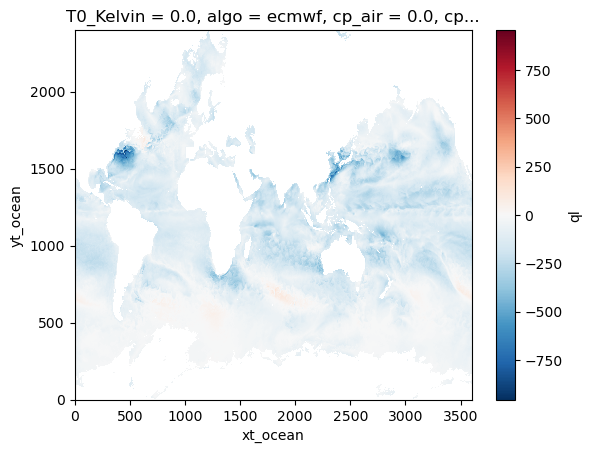

In [8]:
ds_filter_fluxes_prod_dict['CESM'].isel(time=0, algo=0, smoothing=0).ql.plot()

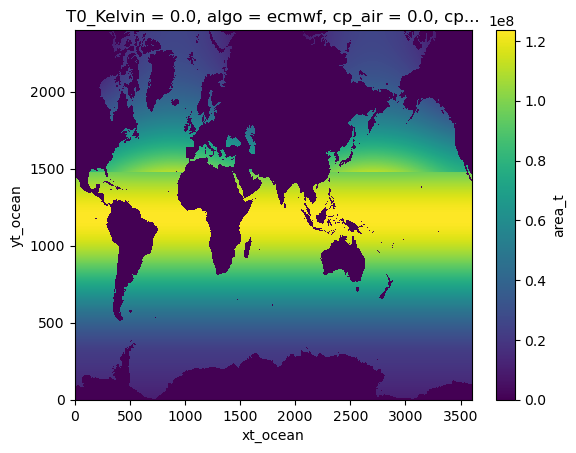

In [9]:
ds_filter_fluxes_prod_dict['CESM'].isel(time=0, algo=0, smoothing=0).area_t.plot()

## Long term mean decompositions (do I need these or can I just do e.g. a monthly one?)

In [10]:
# ds_filter_fluxes_prod_mean_dict = {model:ds.mean('time').persist() for model, ds in ds_filter_fluxes_prod_dict.items()}
ds_filter_fluxes_appendix_mean_dict = {model:ds.mean('time').load() for model, ds in ds_filter_fluxes_appendix_dict.items()}
# ds_coarse_fluxes_prod_mean_dict = {model:ds.mean('time').persist() for model, ds in ds_coarse_fluxes_prod_dict.items()}
# ds_coarse_fluxes_appendix_mean_dict = {model:ds.mean('time').persist() for model, ds in ds_coarse_fluxes_appendix_dict.items()}

In [11]:
# terms = ['Q_star_star', 'Q_star_star_ocean', 'Q_star_star_atmos']
# ds_filter_decomp_prod_mean_dict = {model: decomposition_filter(ds).sel(term=terms) for model,ds in ds_filter_fluxes_prod_mean_dict.items()}

terms = ['Q_star_star', 'Q_star_star_ocean', 'Q_star_star_atmos', 'Q_star_star_vel', 'Q_star_star_tracer']
ds_filter_decomp_appendix_mean_dict = {model: decomposition_filter(ds).sel(term=terms) for model,ds in ds_filter_fluxes_appendix_mean_dict.items()}


KeyboardInterrupt



In [ ]:
ds_filter_decomp_appendix_mean_dict['CESM'].isel(algo=0).to_array()

In [ ]:
# ds_filter_decomp_prod_mean_dict['CESM']#[terms]
da_plot = ds_filter_decomp_appendix_mean_dict['CESM'].isel(algo=0).to_array().load()

In [ ]:
da_plot.plot(col='variable', row='term')#[terms]

In [ ]:
ds_filter_decomp_appendix_mean_dict['CM26'].isel(algo=0).to_array().plot(col='variable', row='term')#[terms]

## Pick up here: 
- Hmm the above does not work nicely... the filtering is not executing?
- Quickly check the long term averages if they look ok
    - CESM looks similar to CM26?
    - Tracer/Vel looks similar to ocean/atmos?
- Decide what output terms/frequencies we actually need
    - Maybe just test that the decomposition of the mean = mean of the decomposition
        - Oh that might not be the case because of the filtering.....
    - Then I can just write out monthly data for prod and daily for appendix? ... and average them later
- Write them all out
- Thats it!

In [16]:
# long terms means of both
# ds_coarse_fluxes_mean = ds_coarse_fluxes.mean('time')
ds_filter_fluxes_mean = ds_filter_fluxes.mean('time')

In [17]:
# persist the means to reduce computation later
# ds_coarse_fluxes_mean = ds_coarse_fluxes_mean.persist()
ds_filter_fluxes_mean = ds_filter_fluxes_mean.persist()

In [18]:
ds_filter_fluxes_monthly = ds_filter_fluxes.resample(time='1MS').mean()
# ds_coarse_fluxes_monthly = ds_coarse_fluxes.resample(time='1MS').mean()

In [19]:
filter_decomp_mean = decomposition_filter(
    ds_filter_fluxes_mean,
    ['Q_star', 'Q_star_star', 'Q_star_star_ocean', 'Q_star_star_atmos', 'Q_star_star_vel', 'Q_star_star_tracer']
)

In [20]:
# coarse_decomp_mean = decomposition_coarse(ds_filter_fluxes_mean, ds_coarse_fluxes_mean)
# # Some checks in the weighted coarsen trigger computation for the first slice (which here is the full dataset). 
# # I persisted both above to only do that once.
# coarse_decomp_mean

In [21]:
# I have an appendix array with all algos, lets save some time and space and only use our reference algo
filter_decomp_monthly = decomposition_filter(ds_filter_fluxes_monthly.sel(algo=primary_algo), ['Q_star_star','Q_H_bar'])

In [22]:
# coarse_decomp_monthly = decomposition_coarse(ds_filter_fluxes_monthly, ds_coarse_fluxes_monthly)

In [23]:
# coarse_decomp_daily = decomposition_coarse(ds_filter_fluxes.sel(algo=primary_algo), ds_coarse_fluxes.sel(algo=primary_algo))
filter_decomp_daily = decomposition_filter(
    ds_filter_fluxes.sel(algo=primary_algo), 
    ['Q_star_star']
)

In [24]:
# 2 year only but with all algos for the appendix
filter_decomp_daily_appendix = decomposition_filter(
    ds_filter_fluxes.sel(time=slice('0181-01-01', '0183-01-01')), 
    ['Q_star_star', 'Q_star_star_ocean', 'Q_star_star_atmos'] # for the case_study.ipynb
)
filter_decomp_daily_appendix

<xarray.Dataset>
Dimensions:   (algo: 5, yt_ocean: 2700, xt_ocean: 3600, time: 731, term: 3)
Coordinates: (12/13)
  * algo      (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
    area_t    (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...        ...
    kmt       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time      (time) object 0181-01-01 12:00:00 ... 0183-01-01 12:00:00
    wet       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * term      (term) <U17 'Q_star_star' 'Q_star_star_ocean' 'Q_star_star_atmos'
Data variables:
    ql        (term, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    qh        (term, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>

### Save out all decompositions

In [25]:
# fs.rm(mapper_filter_flux_decomposition_mean.root, recursive=True)
# fs.rm(mapper_coarse_flux_decomposition_mean.root, recursive=True)
# fs.rm(mapper_filter_flux_decomposition_daily.root, recursive=True)
# fs.rm(mapper_filter_flux_decomposition_daily_appendix.root, recursive=True)
# fs.rm(mapper_coarse_flux_decomposition_daily.root, recursive=True)
# fs.rm(mapper_filter_flux_decomposition_monthly.root, recursive=True)
# fs.rm(mapper_coarse_flux_decomposition_monthly.root, recursive=True)

In [26]:
for ds, mapper, msg in [
    # (filter_decomp_mean, mapper_filter_flux_decomposition_mean, 'Long Term Mean Filter'),
    # (coarse_decomp_mean, mapper_coarse_flux_decomposition_mean, 'Long Term Mean Coarse'),
    # (filter_decomp_monthly, mapper_filter_flux_decomposition_monthly, 'Montlhy Filter'),
    # (coarse_decomp_monthly, mapper_coarse_flux_decomposition_monthly, 'Montlhy Coarse'),
    # (filter_decomp_daily_appendix, mapper_filter_flux_decomposition_daily_appendix, 'Daily Filter (all algos for appendix)'),
    # (filter_decomp_daily, mapper_filter_flux_decomposition_daily, 'Daily Filter'),
    # (coarse_decomp_daily, mapper_coarse_flux_decomposition_daily, 'Daily Coarse'),
]:
    # datasets 'tests'
    assert 'geolon_t' in ds
    assert 'geolat_t' in ds
    
    
    # cluster.scale(200) # if some workers got lost? This might not be the best place to reset this...
    for va in ds.variables:
        if 'chunks' in ds[va].encoding.keys():
            # print(va)
            del ds[va].encoding['chunks']

    print(f"Saving {msg}: {ds.nbytes/1e9}GB")
    if 'time' in ds.dims:
        to_zarr_split(
            ds,
            mapper,
            # split_interval=50 if 'algo' in ds.dims else 150
            split_interval=150 if 'algo' in ds.dims else 450
            # split_interval=60 # less memory pressure on the scheduler. Set back to 60 when using dask-gateway...
        )
    else:
        ds.to_zarr(mapper)

Saving Long Term Mean Filter: 2.799410968GB
Saving Montlhy Filter: 37.79141244GB
Writing to leap-persistent/jbusecke/scale-aware-air-sea/results/CM26_fluxes_filter_decomposed_monthly_v0.7.0.zarr ...


2023-03-20 19:13:04,138 - distributed.client - WARNING - Couldn't gather 2 keys, rescheduling {"('store-map-004067c6f484f93fa57dec3f20a51952', 0, 22, 0, 0)": (), "('store-map-004067c6f484f93fa57dec3f20a51952', 0, 229, 0, 0)": ()}


0it [00:00, ?it/s]

In [5]:
ds = open_zarr(mapper_filter_flux_decomposition_daily)

In [9]:
ds.qh.isel(xt_ocean=2000, yt_ocean=1000).plot()


KeyboardInterrupt



In [13]:
# cluster.shutdown()